In [4]:
import os   
import numpy as np  #
import librosa  
import librosa.display  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split   #
from tensorflow.keras.utils import to_categorical # type: ignore # to convert 
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import plot_model # type: ignore # to convert 
from tensorflow.keras.models import Model # type: ignore # to convert 
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate # type: ignore # to convert 

In [2]:
pip install librosa


  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\PROJECT\\venv\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_internal.pyd'
Consider using the `--user` option or check the permissions.



In [4]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install numpy==1.26.4


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
np.__version__

'1.26.4'

In [6]:
# Define dataset path
TESS_PATH = r"C:\Users\ggani\Downloads\Cross-Attention Transformers for Multimodal Emotion Understanding in Human-Robot Interaction\multimodal emotion recognition in human robots interaction\TESS Toronto emotional speech set data"

In [7]:
# Function to extract MFCC features
def extract_features(audio_path, sr=16000, n_mfcc=40):
    """Loads an audio file and extracts MFCC features.""" # MFCC (Mel-Frequency Cepstral Coefficients)
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc, axis=1)  # Take mean along time axis to get a fixed-length feature vector
    return mfcc


In [8]:
# Load dataset
X_audio, X_text, y = [], [], []
labels_map = {}
label_index = 0
words_set = set()

In [9]:
for root, dirs, files in os.walk(TESS_PATH):
    for file in files:
        if file.endswith(".wav"):  # Ensure it's an audio file
            parts = file.split("_")
            word = parts[1]  # Extract spoken word
            label = parts[-1].replace(".wav", "")  # Extract emotion label from filename
            
            if label not in labels_map:
                labels_map[label] = label_index
                label_index += 1
            
            file_path = os.path.join(root, file)
            features = extract_features(file_path)
            
            X_audio.append(features)
            X_text.append(word)  # Store word as text input
            y.append(labels_map[label])
            words_set.add(word)

In [10]:
# Convert to NumPy arrays
X_audio = np.array(X_audio)
y = np.array(y)
y = to_categorical(y, num_classes=len(labels_map))  # One-hot encode labels


In [11]:
# Encode words as numerical values
word_encoder = LabelEncoder()
X_text = word_encoder.fit_transform(X_text)
X_text = np.expand_dims(X_text, axis=-1)  # Expand dimensions for

In [12]:
# Split into train and test sets
X_audio_train, X_audio_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_audio, X_text, y, test_size=0.2, random_state=42)

In [13]:
# Update model pipeline (ensure it matches expected input shape)
input_shape_audio = (X_audio_train.shape[1],)
input_shape_text = (X_text_train.shape[1],)


In [14]:
print("Dataset Loaded Successfully!")
print(f"Training Samples: {X_audio_train.shape[0]}, Testing Samples: {X_audio_test.shape[0]}")
print(f"Emotion Labels: {labels_map}")
print(f"Unique Words in Dataset: {len(words_set)}")


Dataset Loaded Successfully!
Training Samples: 2240, Testing Samples: 560
Emotion Labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'ps': 5, 'sad': 6}
Unique Words in Dataset: 200


In [15]:
# Define the audio input branch
audio_input = Input(shape=input_shape_audio, name="audio_input")
x_audio = Dense(128, activation="relu")(audio_input)
x_audio = Dropout(0.3)(x_audio)
x_audio = Dense(64, activation="relu")(x_audio)

In [16]:
# Define the text input branch
text_input = Input(shape=input_shape_text, name="text_input")
x_text = Embedding(input_dim=len(words_set) + 1, output_dim=16)(text_input)
x_text = Flatten()(x_text)
x_text = Dense(32, activation="relu")(x_text)

In [17]:
# Fusion layer
merged = Concatenate()([x_audio, x_text])
merged = Dense(64, activation="relu")(merged)
merged = Dropout(0.3)(merged)
output = Dense(len(labels_map), activation="softmax", name="output_layer")(merged)

In [18]:
# Build and compile the model
model = Model(inputs=[audio_input, text_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [19]:
# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      5,248 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 16)     │      3,216 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        544 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 7)         │        455 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,927 (93.46 KB)

 Trainable params: 23,927 (93.46 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Visualize model architecture

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [22]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [20]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [21]:
# Train the model
history = model.fit(
    [X_audio_train, X_text_train], y_train,
    validation_data=([X_audio_test, X_text_test], y_test),
    epochs=30, batch_size=32, verbose=1
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1664 - loss: 18.0300 - val_accuracy: 0.3161 - val_loss: 1.7666
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2041 - loss: 3.1092 - val_accuracy: 0.1589 - val_loss: 1.9452
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1725 - loss: 1.9761 - val_accuracy: 0.1589 - val_loss: 1.9453
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2248 - loss: 1.8909 - val_accuracy: 0.3089 - val_loss: 1.7685
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2729 - loss: 1.7889 - val_accuracy: 0.4339 - val_loss: 1.5569
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3086 - loss: 1.6716 - val_accuracy: 0.4607 - val_loss: 1.4422
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3538 - loss: 1.5307 - val_accuracy: 0.5357 - val_loss: 1.1506
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4034 - loss: 1.4206 - val_accuracy: 0.6893 - val_loss

Text(0.5, 1.0, 'Model Accuracy')

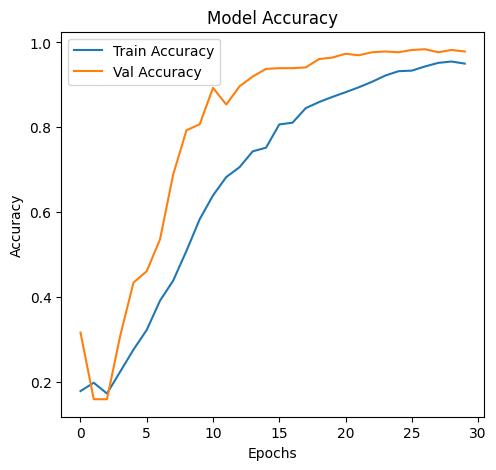

In [22]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

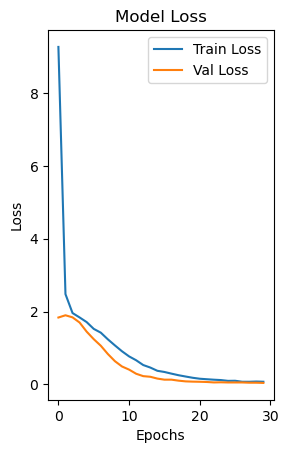

In [24]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix

In [24]:
y_pred = model.predict([X_audio_test, X_text_test])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [35]:
y_pred

array([[1.3038486e-03, 5.8886460e-03, 1.6095523e-04, ..., 1.7549046e-05,
        9.7805905e-01, 4.7119743e-06],
       [1.4213106e-05, 5.8907077e-05, 1.5156700e-04, ..., 3.6102662e-07,
        8.6609073e-02, 4.7588201e-06],
       [4.0118368e-05, 8.1198125e-11, 7.7312166e-09, ..., 8.5907212e-11,
        5.8858807e-11, 1.9204627e-09],
       ...,
       [2.9935813e-04, 2.1639341e-03, 2.8810648e-05, ..., 3.6394083e-06,
        9.9518579e-01, 5.1275612e-07],
       [1.3777653e-06, 3.0652107e-05, 5.6105324e-05, ..., 3.8258772e-08,
        6.7925104e-03, 1.4230952e-06],
       [3.2023121e-20, 9.8852411e-14, 1.6976858e-16, ..., 1.0000000e+00,
        1.9123150e-17, 1.7937507e-15]], dtype=float32)

In [26]:
# Convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

In [27]:
print(f"Accuracy of the model is: {accuracy_score(y_test_labels,y_pred_labels)}")

Accuracy of the model is: 0.9785714285714285


In [28]:
cm = confusion_matrix(y_pred_labels,y_test_labels)

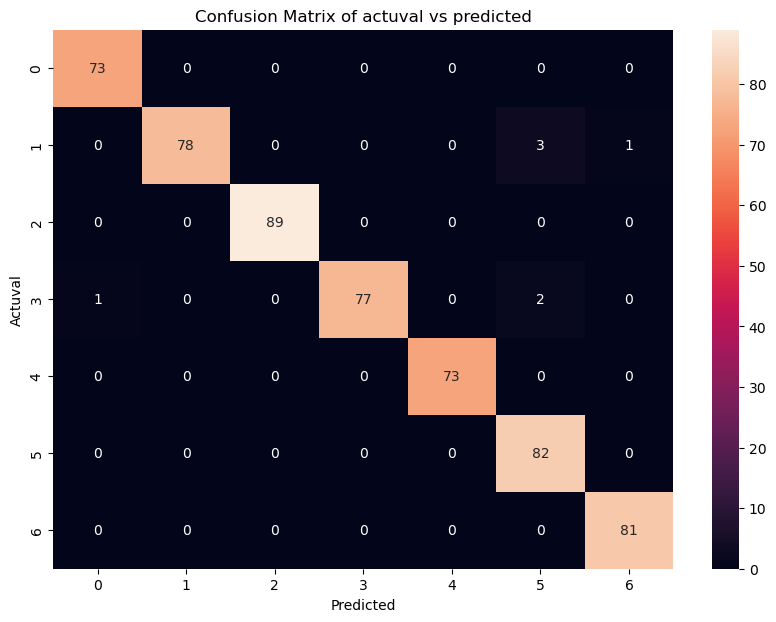

In [39]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True, fmt='g')
plt.ylabel('Actuval')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of actuval vs predicted')
plt.show()

In [29]:
# Evaluate model
eval_results = model.evaluate([X_audio_test, X_text_test], y_test)
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9776 - loss: 0.0634
Test Loss: 0.05562547221779823, Test Accuracy: 0.9785714149475098


In [30]:
from tensorflow.keras.models import load_model
save_dir = "MultiModel  Emotion Recognition Project"
os.makedirs(save_dir, exist_ok=True)

model_file = os.path.join(save_dir, "Multimodel_emotion_recognition_model_lstm.h5")

model.save(model_file)

In [31]:
model_name = 'Multimodel_emotion_recognition_model_lstm.h5'
save_dir = os.path.join(os.getcwd(), 'train_model')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved the trained model at %s ' % model_path)

Saved the trained model at d:\PROJECT\train_model\Multimodel_emotion_recognition_model_lstm.h5 


In [32]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming word_encoder is your LabelEncoder object
np.save('word_encoder_classes.npy', word_encoder.classes_)

In [33]:
word_encoder.classes_ = np.load('word_encoder_classes.npy', allow_pickle=True)

In [ ]:
#word_encoder.classes_ = np.load(r"G:\CODE\word_encoder_classes.npy", allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'G:\\CODE\\word_encoder_classes.npy'

In [35]:
from tensorflow.keras.models import load_model # type: ignore
model = load_model(r"G:\CODE\MultiModel  Emotion Recognition Project\Multimodel_emotion_recognition_model_lstm.h5")
print("Model loaded successfully!")#"G:\CODE\MultiModel  Emotion Recognition Project\Multimodel_emotion_recognition_model_lstm.h5"

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'G:\CODE\MultiModel  Emotion Recognition Project\Multimodel_emotion_recognition_model_lstm.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [47]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [48]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assume 'labels_map' was used in training
labels = ['angry', 'happy', 'sad', 'neutral', 'fear', 'disgust', 'surprise']  # Example emotions
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Save the label encoder
np.save("label_encoder.npy", label_encoder.classes_)


In [49]:
from tensorflow.keras.models import load_model # type: ignore
import numpy as np

# Load the model from the .h5 file
model_path = r"G:\CODE\MultiModel  Emotion Recognition Project\Multimodel_emotion_recognition_model_lstm.h5"  # Replace with your model path
loaded_model = load_model(model_path)
print("Loaded model from disk")

# Compile the model (optional, only needed if the model was not compiled before saving)
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluate the model on test data
# Assuming X_audio_test, X_text_test, and y_test are already loaded
test_loss, test_accuracy = loaded_model.evaluate(
    [X_audio_test, X_text_test],  # Input data (audio and text features)
    y_test,                       # Labels
    verbose=0                     # Set to 1 to see progress
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Loaded model from disk
Test Loss: 0.041998084634542465
Test Accuracy: 98.75%


In [50]:
# Function to classify a new instance
def classify_new_instance(audio_path, spoken_word):
    """Classifies a new audio-text pair."""
    # Extract features from the audio
    audio_features = extract_features(audio_path)
    audio_features = np.expand_dims(audio_features, axis=0)  # Reshape for model
    
    # Encode the spoken word
    if spoken_word in word_encoder.classes_:
        text_features = word_encoder.transform([spoken_word])
        text_features = np.expand_dims(text_features, axis=-1)
    else:
        print("Word not found in vocabulary!")
        return
    
    # Predict emotion
    prediction = model.predict([audio_features, text_features])
    predicted_label = list(labels_map.keys())[np.argmax(prediction)]
    print(f"Predicted Emotion: {predicted_label}")


In [51]:
# Example usage

analyze=classify_new_instance(r"C:\Users\ggani\Downloads\Cross-Attention Transformers for Multimodal Emotion Understanding in Human-Robot Interaction\multimodal emotion recognition in human robots interaction\TESS Toronto emotional speech set data\YAF_happy\YAF_when_happy.wav", "take")

# Example usage
#classify_new_instance(r"G:\CODE\uploads", "take")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted Emotion: happy


In [ ]:
import pickle

pickle.dump()